<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Practice/pr8/Practice8_dre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta

import copy

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm.notebook import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# utils

In [ ]:
def generate_data(n):
    gaussian1 = np.random.normal(loc=-0.5, scale=0.25, size=(n,))
    gaussian2 = np.random.normal(loc=0.5, scale=1, size=(n,))
    return gaussian1, gaussian2

In [ ]:
def plot_data():
    plt.figure()
    x = np.linspace(-3, 3, num=100)
    density_nu = norm.pdf(x, loc=-0.5, scale=0.25)
    density_de = norm.pdf(x, loc=0.5, scale=1)
    plt.figure()
    plt.plot(x, density_nu, label='numerator')
    plt.plot(x, density_de, label='denumenator')
    plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

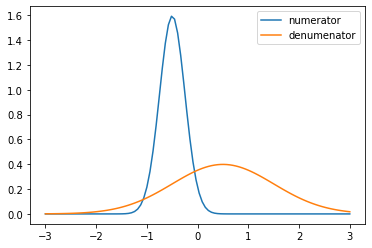

In [ ]:
data_nu, data_de = generate_data(5000)
plot_data()

In [ ]:
def plot_dre(model, title=""):
    with torch.no_grad():
        plt.figure()
        x = np.linspace(-2., 2, num=100)
        density_nu = norm.pdf(x, loc=-0.5, scale=0.25)
        density_de = norm.pdf(x, loc=0.5, scale=1)
        
        ratio_pred = model.r(torch.FloatTensor(x.reshape(-1, 1))).cpu().numpy()

        plt.figure()
        
        plt.plot(x, ratio_pred, label='pred ratio')
        plt.plot(x, density_nu / density_de, label='true ratio')
        
        plt.legend()
        plt.title(title)
        plt.show()

# Notations



*   $p_{nu}(x)$ - pdf of numerator
*   $p_{de}(x)$ - pdf of denominator
*   $r(x)=\frac{p_{nu}(x)}{p_{de}(x)}$ - density ratio
*   $p_{nu}^*, p_{du}^*, r^*$ - estimatinos of respective functions
*   $\{x^{nu}_i\}_{i=1}^{n_{nu}}$ - sample from numerator distribution
*   $\{x^{de}_i\}_{i=1}^{n_{de}}$ - sample from denominator distribution




# Moment matching


*   $r(x)p_{de}(x) = p_{nu}(x)$
*   $argmin ||E_{p_{de}}r^*(x)f(x) - E_{p_{nu}}f(x)||^2$
*   $argmin ||E_{p_{de}}r^*(x)K(\cdot, x) - E_{p_{nu}}K(\cdot, x)||$


In [ ]:
class MeanMatchDRE(nn.Module):
    def __init__(self, hd=128):
        super().__init__()
        self.r = nn.Sequential(nn.Linear(1, hd), 
                               nn.ReLU(),
                               nn.Linear(hd, hd), 
                               nn.ReLU(),
                               nn.Linear(hd, 1),
                               nn.Softplus())
    
    def fit(self, data_nu, data_de, batch_size=512, lr=1e-3, num_epochs=1000):
     
        loader_nu = data.DataLoader(data_nu, 
                                    batch_size=batch_size, 
                                    shuffle=True)
        
        loader_de = data.DataLoader(data_de, 
                                    batch_size=batch_size, 
                                    shuffle=True)
        

        optim = opt.Adam(self.r.parameters(), lr=lr)


        for epoch in tqdm(range(num_epochs)):
            for (batch_nu, batch_de) in zip(loader_nu, loader_de):
                batch_nu = batch_nu.view(-1, 1).float()
                batch_de = batch_de.view(-1, 1).float()

                loss = ((self.r(batch_de) * batch_de).mean() - batch_nu.mean()) ** 2

                optim.zero_grad()
                loss.backward()
                optim.step()

In [ ]:
model1 = MeanMatchDRE()
model1.fit(data_nu, data_de)

  0%|          | 0/1000 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

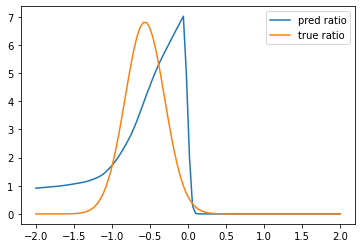

In [ ]:
plot_dre(model1)

In [ ]:
class MomentMatchDRE(nn.Module):
    def __init__(self, hd=128, k=1):
        super().__init__()
        self.r = nn.Sequential(nn.Linear(1, hd), 
                               nn.ReLU(),
                               nn.Linear(hd, hd), 
                               nn.ReLU(),
                               nn.Linear(hd, 1),
                               nn.Softplus())
        
        self.k = k
    
    def fit(self, data_nu, data_de, batch_size=512, lr=1e-3, num_epochs=1000):
     
        loader_nu = data.DataLoader(data_nu, 
                                    batch_size=batch_size, 
                                    shuffle=True)
        
        loader_de = data.DataLoader(data_de, 
                                    batch_size=batch_size, 
                                    shuffle=True)
        

        optim = opt.Adam(self.r.parameters(), lr=lr)


        for epoch in tqdm(range(num_epochs)):
            for (batch_nu, batch_de) in zip(loader_nu, loader_de):
                batch_nu = batch_nu.view(-1, 1).float()
                batch_de = batch_de.view(-1, 1).float()

                moment_de = 1
                moment_nu = 1
                loss = 0
                r_de = self.r(batch_de)

                for i in range(1, self.k + 1):
                    
                    loss += ((r_de * (batch_de) ** i).mean() - (batch_nu ** i).mean()) ** 2

                optim.zero_grad()
                loss.backward()
                optim.step()

In [ ]:
models = []
for i in range(8):
    model = MomentMatchDRE(k = i + 1)
    model.fit(data_nu, data_de)
    models.append(model)

<Figure size 432x288 with 0 Axes>

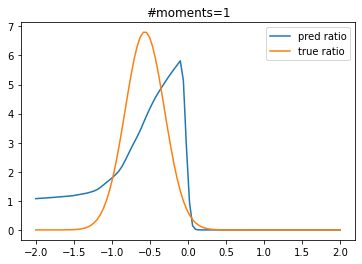

<Figure size 432x288 with 0 Axes>

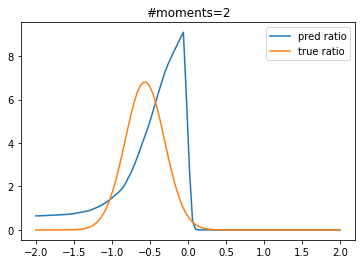

<Figure size 432x288 with 0 Axes>

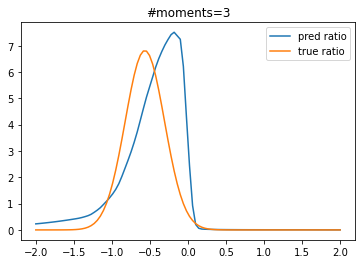

<Figure size 432x288 with 0 Axes>

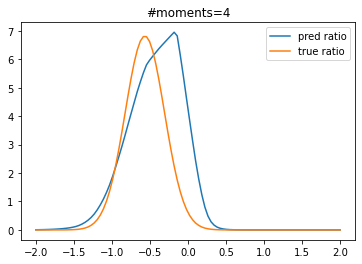

<Figure size 432x288 with 0 Axes>

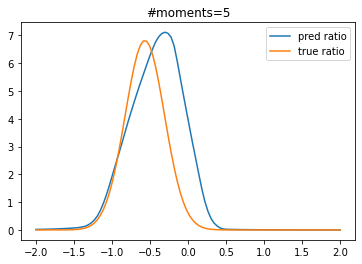

<Figure size 432x288 with 0 Axes>

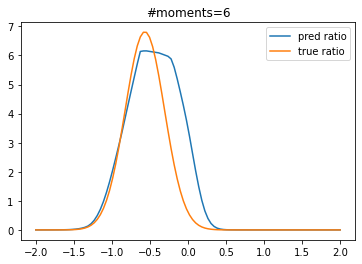

<Figure size 432x288 with 0 Axes>

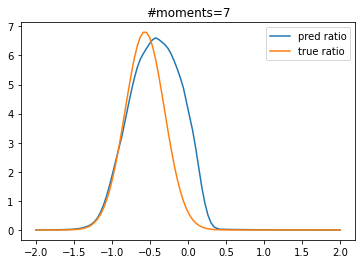

<Figure size 432x288 with 0 Axes>

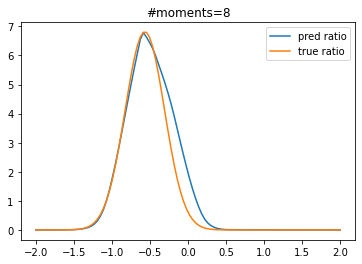

In [ ]:
for i in range(8):
    plot_dre(models[i], f'#moments={i+1}')

<Figure size 432x288 with 0 Axes>

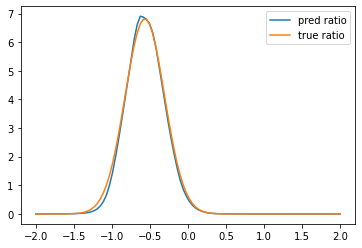

In [ ]:
# dre with kmm

# Probability Classifaction



*   numerator: $y=1$ 
*   denominator: $y=0$
* $p_{nu}(x) = p(x| y=1)$
* $p_{de}(x) = p(x| y=0)$
* $d(x) \sim p(y=1|x)$
* $r(x) = \frac{p(y=1)}{p(y=0)}\frac{p(y=1|x)}{p(y=0|x)}$



In [ ]:
class ProbClassDRE(nn.Module):
    def __init__(self, hd=128):
        super().__init__()
        self.f = nn.Sequential(nn.Linear(1, hd), 
                               nn.ReLU(),
                               nn.Linear(hd, hd), 
                               nn.ReLU(),
                               nn.Linear(hd, 1),
                               nn.Sigmoid())
    
    def r(self, x):
        return self.f(x) / (1 - self.f(x))
    
    def fit(self, data_nu, data_de, batch_size=512, lr=1e-3, num_epochs=1000):
     
        loader_nu = data.DataLoader(data_nu, 
                                    batch_size=batch_size, 
                                    shuffle=True)
        
        loader_de = data.DataLoader(data_de, 
                                    batch_size=batch_size, 
                                    shuffle=True)
        

        optim = opt.Adam(self.f.parameters(), lr=lr)


        for epoch in tqdm(range(num_epochs)):
            for (batch_nu, batch_de) in zip(loader_nu, loader_de):
                batch_nu = batch_nu.view(-1, 1).float()
                batch_de = batch_de.view(-1, 1).float()
                batch = torch.cat((batch_nu, batch_de), dim=0)
                labels = torch.hstack((torch.ones(len(batch_nu)), torch.zeros(len(batch_de)))).view(-1, 1)


                loss = F.binary_cross_entropy(self.f(batch), labels)

                optim.zero_grad()
                loss.backward()
                optim.step()

In [ ]:
modelpr = ProbClassDRE()
modelpr.fit(data_nu, data_de)

  0%|          | 0/1000 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

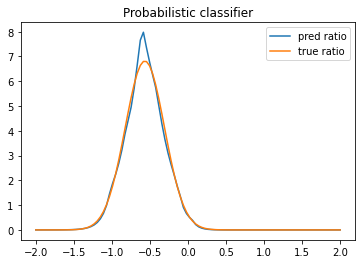

In [ ]:
plot_dre(modelpr, 'Probabilistic classifier')

# Density matching

*   $r(x)p_{de}(x) = p_{nu}(x)$
* $KL(p_{nu}||p_{nu}^*) = C - E_{p_{nu}}\log r^*(x)$
* $E_{p_{de}}r^*(x)=1$

(KLIEP - KL importance estimation procedure)

# Density Ratio fitting

* $\frac 12 E_{p_{de}} (r(x) - r^*(x))^2$

(LSIF - leaast-squares importance fitting)

# Bregman divergence

* $f$ - continuously-differentiable and strictly convex
* $BR_f(x||x^*) = f(x) - f(x^*) - ∂ f(x^*) \cdot ( x - x^*)$
* $BR_f(r||r^*) = E_{p_{de}}f(r(x)) - f(r^*(x)) - ∂ f(r^*(x)) \cdot (r(x) - r^*(x))$
* $f(x) = x \log(x) - (x+1)\log(x+1)$
